In [1]:
from pathlib import Path
import logging
import math
import shutil

import pytorch_lightning as pl
import matplotlib.pyplot as plt
from torch.nn.functional import softmax
import torch
import numpy as np
from torchvision import transforms
from pytorch_lightning import seed_everything
from tqdm import tqdm
import pandas as pd
from PIL import Image
from sunpy.net import Fido, attrs as a

from solarnet.utils.plots import plot_confusion_matrix, plot_image_grid
from solarnet.utils.target import flux_to_class_builder
from solarnet.utils.log import init_log, set_log_level
from solarnet.models import ImageClassification
from solarnet.data import SDOBenchmarkDataModule, SDODatasetDataModule, SDODataset
from solarnet.utils.yaml import load_yaml
from solarnet.data import datamodule_from_config
from solarnet.data.transforms import sdo_dataset_normalize, SDOSimCLRDataTransform
from solarnet.utils.plots import plot_confusion_matrix
from solarnet.utils.metrics import classification_metrics
from solarnet.data.events.flares import get_flares_from_cache

init_log()
set_log_level(logging.INFO)

/home/jonathan.donzallaz/anaconda3/envs/solarnet-conda-env/lib/python3.8/site-packages/pytorch_lightning/core/decorators.py:64: LightningDeprecationWarning: The `@auto_move_data` decorator is deprecated in v1.3 and will be removed in v1.5. Please use `trainer.predict` instead for inference. The decorator was applied to `forward`
  rank_zero_deprecation(


In [8]:
p = Path("/data1/data")
# p = Path("data1/data")
p = p / Path("sdo/abc/test.pt")
p.is_absolute()
p

PosixPath('/data1/data/sdo/abc/test.pt')

In [2]:
# available:
# jp2 files 1024x1024 soho 1996-2011
# jp2 files 4096x4096 sdo  2010-2022
# csv files with id, date, name, scale, width, height, refPixelX, refPixelY, requested_date, path, observatory, instrument, wavelength

# needed:
# jp2/pt file prepared with correct name, in correct folder
# csv file with path, label, datetime, split

# todo:
# remove sample >30min further
# preprocess
#   -> resize 512 px
#   -> remove black circle
#   -> rescale same radius
#   -> resize to 128 px
#   -> center-crop
#   -> normalize 0.5 0.5
# all of basic dataset preparation

In [124]:
resize = 128
mean_pooling = 512
remove_black_background = True
rescale_radius = True
center_crop = (8, 2)
standard_scaling = True

In [125]:
def filter_sample_not_in_range(samples:pd.DataFrame, range:int, column1:str, column2:str) -> pd.DataFrame:
    df = samples.copy()
    df[column1] =  pd.to_datetime(df[column1])
    df[column2] =  pd.to_datetime(df[column2])
    df['time_delta'] = abs((df[column1] - df[column2]).dt.total_seconds())
    
    return samples[df.time_delta < range]

In [139]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [126]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def preprocess_image(img: Image.Image, resize: int = 128, scale: float = 0.6):
    # t1 = time.perf_counter()
    size = img.size[0]

    # Remove black background around the sun in jpg images
    R_SUN = 976
    radius_pixels = R_SUN / 0.6  # ~= 1626px (for a 4096x4096 image)
    radius_factor = radius_pixels / 4096
    radius_factor *= 0.983  # to remove black margin around the sun

    mask = create_circular_mask(size, size, center=(size//2, size//2), radius=size * radius_factor)
    def remove_background(x):
        x_copy = x.clone()
        if len(x.shape) == 3:
            x_copy[0][~mask] = 0.5
        else:
            x_copy[~mask] = 0.5
        return x_copy
    
    # Downsizing by averaging in local blocks
    target_mean_size = max(512, resize)
    factor = size // target_mean_size
    mean_downsize = lambda x: torch.nn.functional.avg_pool2d(x, factor)

    scale_factor = scale / 0.6
    # print(scale_factor)

    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            # transforms.Lambda(lambda x: x.to(device)),
            transforms.Lambda(lambda x: transforms.functional.affine(x, angle=0, translate=[-0.5,1], scale=scale_factor, shear=0)),
            transforms.Lambda(remove_background),
            transforms.Lambda(mean_downsize),
            # transforms.Lambda(lambda x: mean_downsize(remove_background(transforms.functional.affine(x, angle=0, translate=[-0.5,1], scale=scale_factor, shear=0)))),

            # transforms.CenterCrop((target_mean_size // 2, target_mean_size - target_mean_size // 8)),

            # transforms.Resize(resize),

            # transforms.Resize(resize, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ]
    )
    # print(f"time: {time.perf_counter()-t1:.2f}s")
    # t1 = time.perf_counter()
    t = transform(img)
    # print(f"time: {time.perf_counter()-t1:.2f}s")
    return t

In [114]:
# path = Path("/data1/data/sdo-dataset-jp2/HMI_magnetogram_20101206T070000.jp2")
# path = Path("/data1/data/sdo-dataset-jp2/HMI_magnetogram_20210716T080000.jp2")
# scale = 0.5913470398078333
# scale = 0.609966
# img = Image.open(path, formats=["JPEG2000"])
        
# # tensor = preprocess_image(img, resize=512, scale=scale, center=(2048+0.5, 2048-1))
# tensor = preprocess_image(img, resize=512, scale=scale, center=(2048, 2048))

# # save_path = Path(".") / f"{path.stem}.pt"
# # torch.save(tensor, save_path)
# plt.figure(figsize=(15,15))
# plt.imshow(tensor.squeeze(), cmap="Greys_r");

In [115]:
# def preprocess_jp2(df: pd.DataFrame, output: Path):
#     output.mkdir(parents=True, exist_ok=True)

#     for sample in df.to_dict("records"):
#         path = Path(sample["path"])
#         img = Image.open(path, formats=["JPEG2000"])
        
#         tensor = preprocess_image(img, sample["scale"])

#         save_path = output / f"{path.stem}.pt"
#         torch.save(tensor, save_path)

In [127]:
df = pd.read_csv(
    "../downloaded_data_soho.csv",
    # names=["id", "date", "name", "scale", "width", "height", "refPixelX", "refPixelY", "requested_date", "path", "observatory", "instrument", "wavelength"],
    parse_dates=["date", "requested_date"],
)
print(len(df))
df = filter_sample_not_in_range(df, 60 * 30, "date", "requested_date")

print(len(df))
df.head()

129095
70558


id                date     name  ...  observatory  instrument   wavelength
1  2176239 1996-04-21 00:30:04  MDI Mag  ...         soho         MDI  magnetogram
2  2176236 1996-04-21 02:06:04  MDI Mag  ...         soho         MDI  magnetogram
4  2176237 1996-04-21 03:45:04  MDI Mag  ...         soho         MDI  magnetogram
5  2176241 1996-04-21 05:21:04  MDI Mag  ...         soho         MDI  magnetogram
9  2176238 1996-04-21 08:33:04  MDI Mag  ...         soho         MDI  magnetogram

[5 rows x 13 columns]

In [128]:
# preprocess_jp2(df, Path("/data1/data/sdo-dataset-jp2-pp"))
records = df.to_dict("records")

In [129]:
import time
from multiprocessing import Pool, get_context

dest_path = Path("/data1/data/sdo-dataset-jp2-cleaned/")
dest_path.mkdir(parents=True, exist_ok=True)

def process_sample(sample):
    path = Path(sample["path"])
    obs = sample["observatory"].upper()
    inst = sample["instrument"].upper()
    wl = sample["wavelength"]
    scale = sample["scale"]
    date = sample["date"]
    date = date.round("min")

    year = str(date.year)
    month = f"{date.month:02d}"
    day = f"{date.day:02d}"
    hours = f"{date.hour:02d}"
    minutes = f"{date.minute:02d}"

    new_path = dest_path / f"{obs}_{inst}_{wl}_{year}{month}{day}_{hours}{minutes}.pt"

    # print(f"time: {time.perf_counter()-t1:.2f}s")
    # t1 = time.perf_counter()
    image = Image.open(path, formats=["JPEG2000"])
    # print(f"time: {time.perf_counter()-t1:.2f}s")
    # t1 = time.perf_counter()
    tensor = preprocess_image(image, resize=512, scale=scale)
    # print(f"time: {time.perf_counter()-t1:.2f}s")
    # t1 = time.perf_counter()
    torch.save(tensor, new_path)
    # print(f"time: {time.perf_counter()-t1:.2f}s")

    # shutil.copy2(path, new_path)

t1 = time.perf_counter()
# p = Pool(4)
with get_context("fork").Pool(10) as pool:
    pool.map(process_sample, records[:20])
    # tqdm(p.imap(process_sample, records[:100]), total=100)
# for sample in tqdm(records[:100]): # 5:40
    # process_sample(sample)
    # print(sample)
    # t1 = time.perf_counter()

    # break
print(f"time: {time.perf_counter()-t1:.2f}s")

time: 1.81s


In [72]:
def show(img, size=15):
    if isinstance(img, Path) or isinstance(img, str):
        img = Image.open(img)
    elif isinstance(img, Image.Image):
        pass
    elif isinstance(img, torch.Tensor):
        while len(img.shape) > 2:
            img = img.squeeze()
    else:
        return
    plt.figure(figsize=(size,size))
    plt.imshow(img, cmap="Greys_r")
    plt.show()

In [24]:
p1 = df.path.values[800]  # '/data1/data/sdo-dataset-jp2-soho/MDI_magnetogram_19960621T220000.jp2'
p2 = df.path.values[3362]  # '/data1/data/sdo-dataset-jp2-soho/MDI_magnetogram_19961221T220000.jp2'
p1 = df.path.values[70527]  # '/data1/data/sdo-dataset-jp2-soho/MDI_magnetogram_19960621T220000.jp2'
p2 = df.path.values[69535]  # '/data1/data/sdo-dataset-jp2-soho/MDI_magnetogram_19961221T220000.jp2'
s1 = df.scale.values[800]
s2 = df.scale.values[3362]
s1 = df.scale.values[70527]
s2 = df.scale.values[69535]
img1 = Image.open(p1)
img2 = Image.open(p2)
p1, p2, s1, s2

('/data1/data/sdo-dataset-jp2-soho/MDI_magnetogram_20110103T180000.jp2',
 '/data1/data/sdo-dataset-jp2-soho/MDI_magnetogram_20100705T060000.jp2',
 1.925632767405324,
 1.991059399608172)

In [25]:
df.scale.values.min(), df.scale.values.max()
# df.scale.values.argmin(), df.scale.values.argmax()

(1.925632767405324, 1.991059399608172)

In [130]:
def preprocess_image(img: Image.Image, resize: int = 128, scale: float = 0.6):
    size = img.size[0]

    BASE_SIZE_SDO = 4096
    BASE_RADIUS_SDO = 1600  # px, of the 4096 px image
    BASE_SCALE_SDO = 0.6

    BASE_SIZE_SOHO = 1024
    BASE_RADIUS_SOHO = 968  # px, of the 1024 px image
    BASE_SCALE_SOHO = 1.97784

    # Remove black background around the sun in jpg images
    radius_factor = (BASE_RADIUS_SDO-1)/BASE_SIZE_SDO  # -1, to remove the thin black margin

    mask = create_circular_mask(size, size, center=(size//2, size//2), radius=size * radius_factor)
    def remove_background(x):
        x_copy = x.clone()
        if len(x.shape) == 3:
            x_copy[0][~mask] = 0.5
        else:
            x_copy[~mask] = 0.5
        return x_copy
    
    # Downsizing by averaging in local blocks
    target_mean_size = max(512, resize)
    factor = size // target_mean_size
    mean_downsize = lambda x: torch.nn.functional.avg_pool2d(x, factor)

    if scale < 1:  # SDO
        scale_factor = scale / BASE_SCALE_SDO
        translate = [-0.5,1]
    else:
        scale_soho_to_sdo_factor = (BASE_RADIUS_SDO / BASE_SIZE_SDO) / (BASE_RADIUS_SOHO / BASE_SIZE_SOHO) * 2
        scale_factor = scale / BASE_SCALE_SOHO * scale_soho_to_sdo_factor
        translate = [0.5,0.5]

    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Lambda(lambda x: transforms.functional.affine(x, angle=0, translate=translate, scale=scale_factor, shear=0)),
            transforms.Lambda(remove_background),
            transforms.Lambda(mean_downsize),
            # transforms.Resize(resize),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ]
    )
    return transform(img)

In [131]:
R_SUN = 976
radius_pixels = R_SUN / 0.6  # ~= 1626px (for a 4096x4096 image)
radius_factor = radius_pixels / 4096
radius_factor *= 0.983
4096 * radius_factor
radius_factor

0.39038411458333333

In [132]:
484.0917364397524*2

968.1834728795048

In [133]:
0.78125 / (0.4727458363669457 * 2)
# 0.4727458363669457 * 1024
# 484.0917364397524 / 512 

0.8262896676191909

In [134]:
1600 / 4096 * 2

0.78125

In [135]:
(1600 / 4096) / (968 / 1024) * 2

0.8264462809917356

In [136]:
# show(img2,15)
show(preprocess_image(img2, scale=s2),15)

NameError: name 'img2' is not defined

In [152]:
img = Image.open("/data1/data/sdo-dataset-jp2-soho/MDI_magnetogram_20041214T190000.jp2")
t = transforms.ToTensor()(img)

In [156]:
t[0,200:800,200:800].mean()
# t.shape

tensor(0.5233)

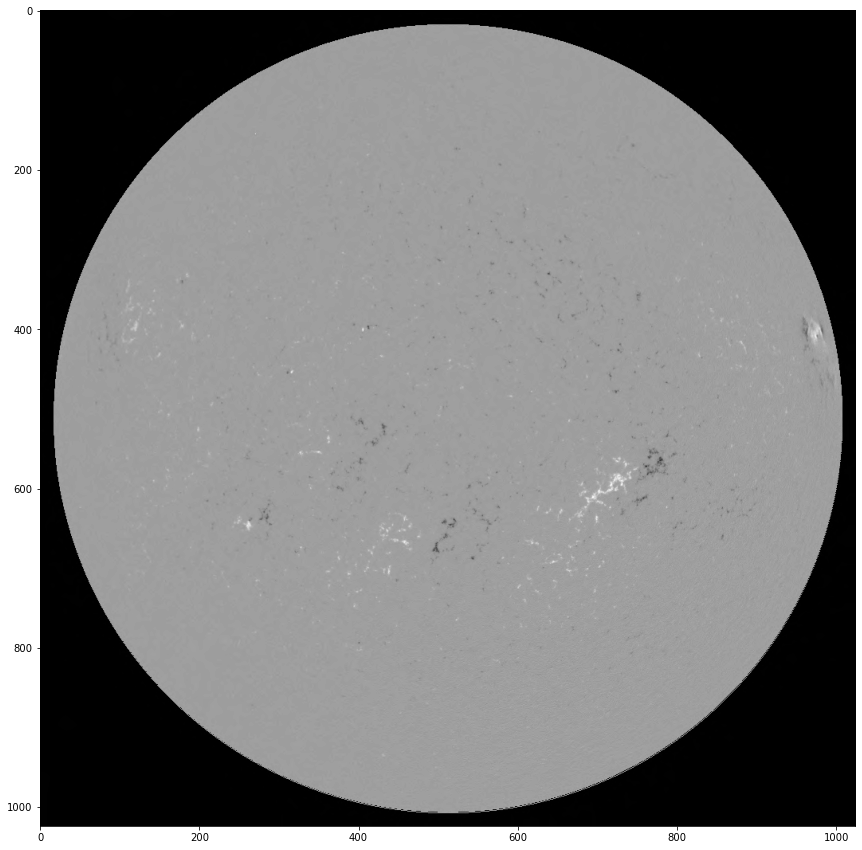

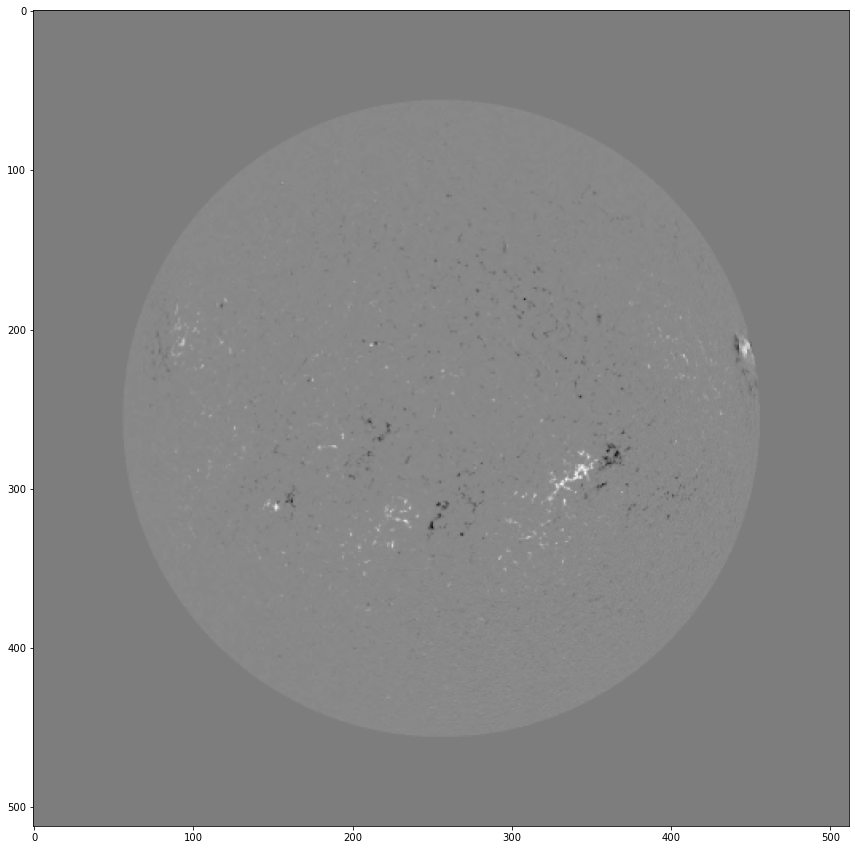

In [139]:
# img = Image.open("/data1/data/sdo-dataset-jp2-soho/MDI_magnetogram_20041214T190000.jp2")
img = Image.open("/data1/data/sdo-dataset-jp2/HMI_magnetogram_20111206T070000.jp2")
show(img)
show(preprocess_image(img, scale=0.5914082839950475))
# show(preprocess_image(img, scale=1.98))

In [153]:
t = torch.load("/data1/data/sdo-dataset-jp2-cleaned/SDO_HMI_magnetogram_20101206_0700.pt")
plt.figure(figsize=(15,15))
plt.imshow(t.squeeze(), cmap="Greys_r");

In [12]:
pd.Timestamp("2010-05-01T10:05:00").strftime("%Y%m%d_%H%M")
# pd.Timestamp("2010-05", )
# from datetime import datetime
# datetime.fromisoformat("2010-05-01T10:05:00").form

'20100501_1005'

In [2]:
df = get_flares_from_cache(pd.Timestamp("1996-04-21T00:00:00"), pd.Timestamp("2018-12-31T23:59:59"))

INFO     | Loading flares from cache


In [11]:
df = pd.read_csv("../data/hv-test/hv-train.csv")
len(df)
# df.head()

90881

In [161]:
i = 3030
path = df.path_0_before.values[i]
date = df.datetime.values[i]
t = torch.load(path)
show(t)
date
t.shape

torch.Size([1, 512, 512])

In [163]:
torch.stack([t]).shape

torch.Size([1, 1, 512, 512])

In [164]:
p = "../data/sdo-dataset-ssl-bz-1h-month/Bz/2010/05/14/HMI20100514_0000_bz.npz"
t = torch.from_numpy(np.load(p)["x"])
t.shape
torch.stack([t]).shape

torch.Size([1, 512, 512])

In [ ]:
# ================================

In [8]:
df = pd.read_csv("../data/ssl-bz-1h-1996-2011-jp2-sdoml/sdo-dataset-train.csv")
len(df)

76104

In [26]:
df.iloc[63280:63300]

path_0_before     peak_flux  \
63280  sdo-dataset-jp2-cleaned/SOHO_MDI_magnetogram_2...  1.000000e-09   
63281  sdo-dataset-jp2-cleaned/SOHO_MDI_magnetogram_2...  1.000000e-09   
63282  sdo-dataset-jp2-cleaned/SOHO_MDI_magnetogram_2...  1.000000e-09   
63283  sdo-dataset-jp2-cleaned/SOHO_MDI_magnetogram_2...  1.000000e-09   
63284  sdo-dataset/Bz/2010/05/01/HMI20100501_0012_bz.npz  1.000000e-09   
63285  sdo-dataset/Bz/2010/05/01/HMI20100501_0100_bz.npz  5.700000e-06   
63286  sdo-dataset/Bz/2010/05/01/HMI20100501_0200_bz.npz  1.000000e-09   
63287  sdo-dataset/Bz/2010/05/01/HMI20100501_0300_bz.npz  1.000000e-09   
63288  sdo-dataset/Bz/2010/05/01/HMI20100501_0400_bz.npz  1.000000e-09   
63289  sdo-dataset/Bz/2010/05/01/HMI20100501_0500_bz.npz  1.600000e-07   
63290  sdo-dataset/Bz/2010/05/01/HMI20100501_0548_bz.npz  1.000000e-09   
63291  sdo-dataset/Bz/2010/05/01/HMI20100501_0700_bz.npz  1.000000e-09   
63292  sdo-dataset/Bz/2010/05/01/HMI20100501_0800_bz.npz  1.000000e-09   
63293  sdo-dataset/Bz/2010/05/01/HMI20100501_0900_bz.npz  1.000000e-07   
63294  sdo-dataset/Bz/2010/05/01/HMI20100501_1000_bz.npz  1.000000e-09   
63295  sdo-dataset/Bz/2010/05/01/HMI20100501_1100_bz.npz  1.000000e-09   
63296  sdo-dataset/Bz/2010/05/01/HMI20100501_1200_bz.npz  1.000000e-09   
63297  sdo-dataset/Bz/2010/05/01/HMI20100501_1300_bz.npz  1.000000e-09   
63298  sdo-dataset/Bz/2010/05/01/HMI20100501_1400_bz.npz  1.000000e-09   
63299  sdo-dataset/Bz/2010/05/01/HMI20100501_1500_bz.npz  1.000000e-09   

                  datetime  all_found  split  
63280  2010-04-29 18:00:00      False  train  
63281  2010-04-30 03:00:00      False  train  
63282  2010-04-30 05:00:00      False  train  
63283  2010-04-30 06:00:00      False  train  
63284  2010-05-01 00:00:00      False  train  
63285  2010-05-01 01:00:00       True  train  
63286  2010-05-01 02:00:00       True  train  
63287  2010-05-01 03:00:00       True  train  
63288  2010-05-01 04:00:00       True  train  
63289  2010-05-01 05:00:00       True  train  
63290  2010-05-01 06:00:00      False  train  
63291  2010-05-01 07:00:00       True  train  
63292  2010-05-01 08:00:00       True  train  
63293  2010-05-01 09:00:00       True  train  
63294  2010-05-01 10:00:00       True  train  
63295  2010-05-01 11:00:00       True  train  
63296  2010-05-01 12:00:00       True  train  
63297  2010-05-01 13:00:00       True  train  
63298  2010-05-01 14:00:00       True  train  
63299  2010-05-01 15:00:00       True  train

In [31]:
Path(df.iloc[63299].path_0_before).suffix

'.npz'